In [2]:
# !pip install tfimm
# !pip install timm

In [3]:
import os
import cv2
import timm
import tfimm
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_addons as tfa
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

In [4]:
batch_size = 32
img_size = 224
input_shape = [img_size, img_size, 3]
epochs = 10

num_classes = 1

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
path = Path('../input/disease')
data_dir = path / 'chest_xray'
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

files = (tf.io.gfile.glob(str(train_dir) + '/*/*'))
files.extend(tf.io.gfile.glob(str(val_dir) + '/*/*'))

test_data = (tf.io.gfile.glob(str(test_dir) + '/*/*'))

In [6]:
train_data, val_data = train_test_split(files, test_size=0.20)

train_ds = tf.data.Dataset.from_tensor_slices(train_data)
val_ds = tf.data.Dataset.from_tensor_slices(val_data)
test_ds = tf.data.Dataset.from_tensor_slices(test_data)

train_image_count = tf.data.experimental.cardinality(train_ds)
val_image_count = tf.data.experimental.cardinality(val_ds)
test_image_count = tf.data.experimental.cardinality(test_ds)

print(f"size of train dataset : {train_image_count}")
print(f"size of val dataset : {val_image_count}")
print(f"size of test dataset : {test_image_count}")

size of train dataset : 4185
size of val dataset : 1047
size of test dataset : 624


2022-04-06 13:15:45.659712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:15:45.660814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:15:45.661547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 13:15:45.663648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
class_names = np.unique(sorted([item.name for item in data_dir.glob('*/*/')]))
print(f"class names : {class_names}")

normal = (tf.io.gfile.glob(str(train_dir) + '/NORMAL/*'))
pneumonic = (tf.io.gfile.glob(str(train_dir) + '/PNEUMONIA/*'))

normal_image_count = len(normal)
pneumonic_image_count = len(pneumonic)
total = normal_image_count + pneumonic_image_count

weight_for_normal = (1 / normal_image_count) * (total / 2.0)
weight_for_pneumonic = (1 / pneumonic_image_count) * (total / 2.0)

class_weights = {0: weight_for_normal, 1: weight_for_pneumonic}

print('Weight for class 0: {:.2f}'.format(weight_for_normal))
print('Weight for class 1: {:.2f}'.format(weight_for_pneumonic))

class names : ['NORMAL' 'PNEUMONIA']
Weight for class 0: 1.94
Weight for class 1: 0.67


Normal Images-----------


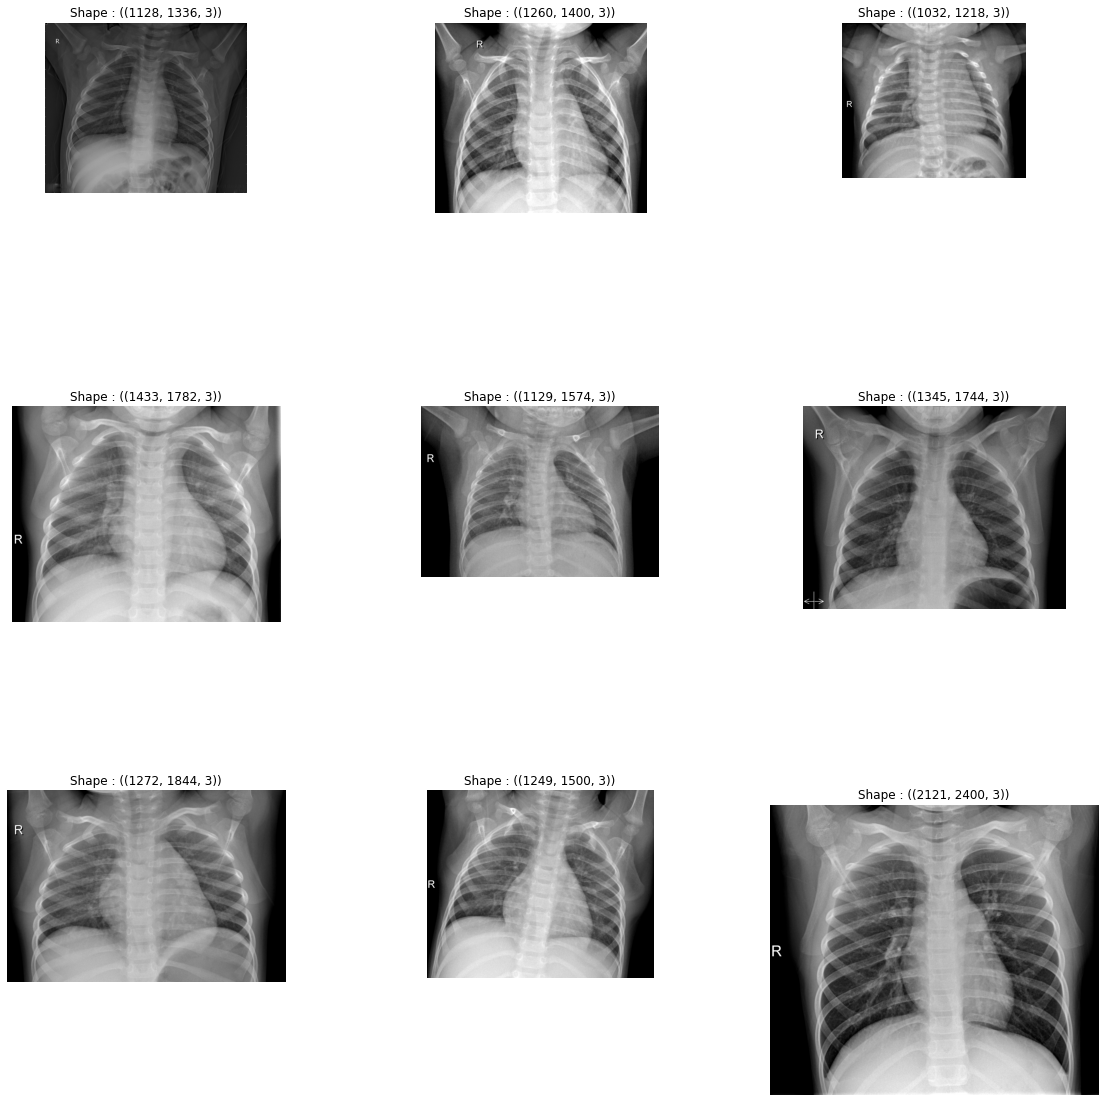

In [8]:
print("Normal Images-----------")
fig, ax = plt.subplots(3, 3 , figsize = (20, 20), sharey =True)
for i in range(9):
    img = cv2.imread(normal[i])
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].set_title(f"Shape : ({img.shape})")
    ax[i//3, i%3].axis('off')

Pneumonic Images--------


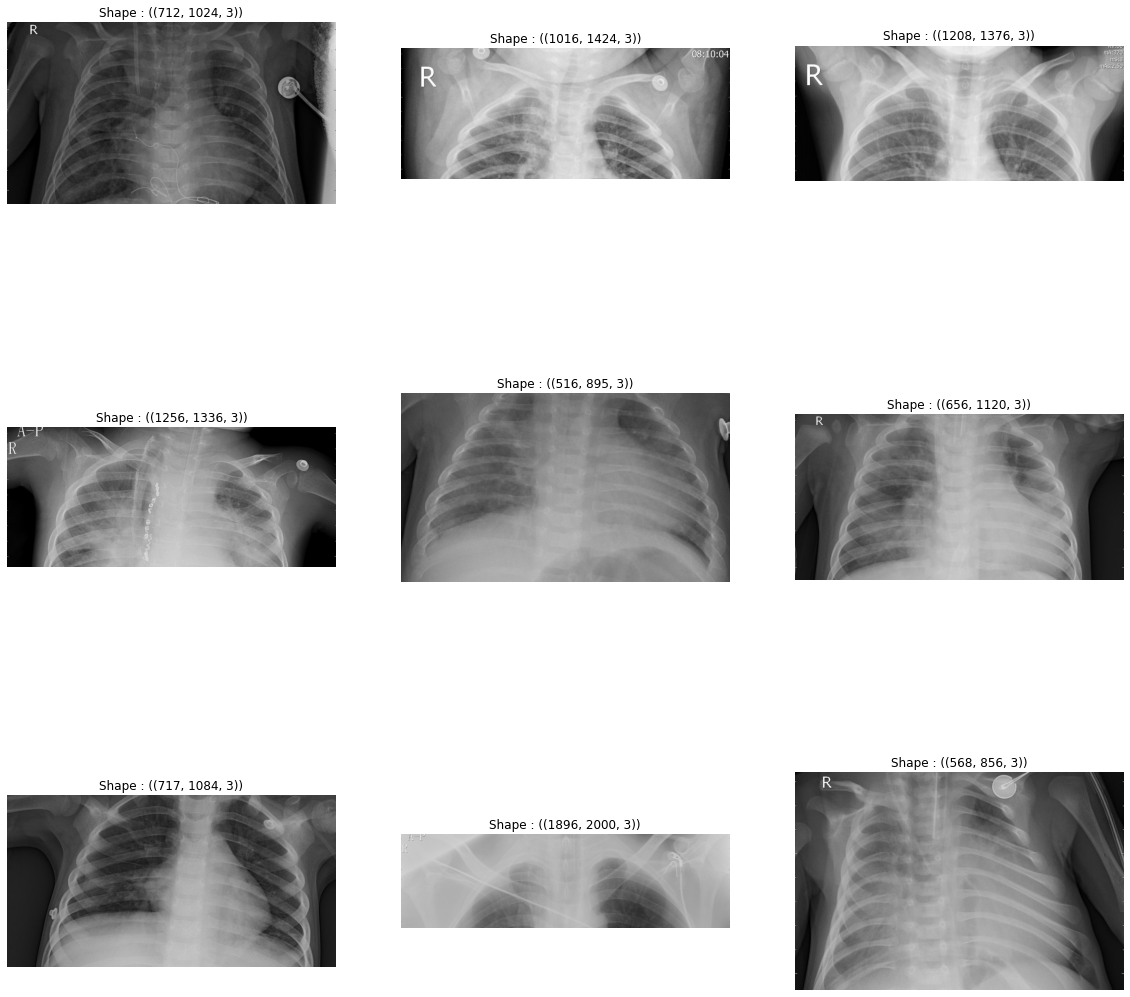

In [9]:
print("Pneumonic Images--------")
fig, ax = plt.subplots(3, 3 , figsize = (20, 20), sharey =True)
for i in range(9):
    img = cv2.imread(pneumonic[i])
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].set_title(f"Shape : ({img.shape})")
    ax[i//3, i%3].axis('off')

In [10]:
def encode_decode(file_path = data_dir):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (img_size, img_size))

    label = tf.strings.split(file_path, sep = '/')[-2]
    oneHot = label == class_names
    encode_label = tf.argmax(oneHot)
    return (img, encode_label)
  
train_ds = train_ds.map(encode_decode, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(encode_decode, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.map(encode_decode, num_parallel_calls = AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size = 1000).batch(batch_size).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size = 1000).batch(batch_size).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)

2022-04-06 13:15:57.686215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


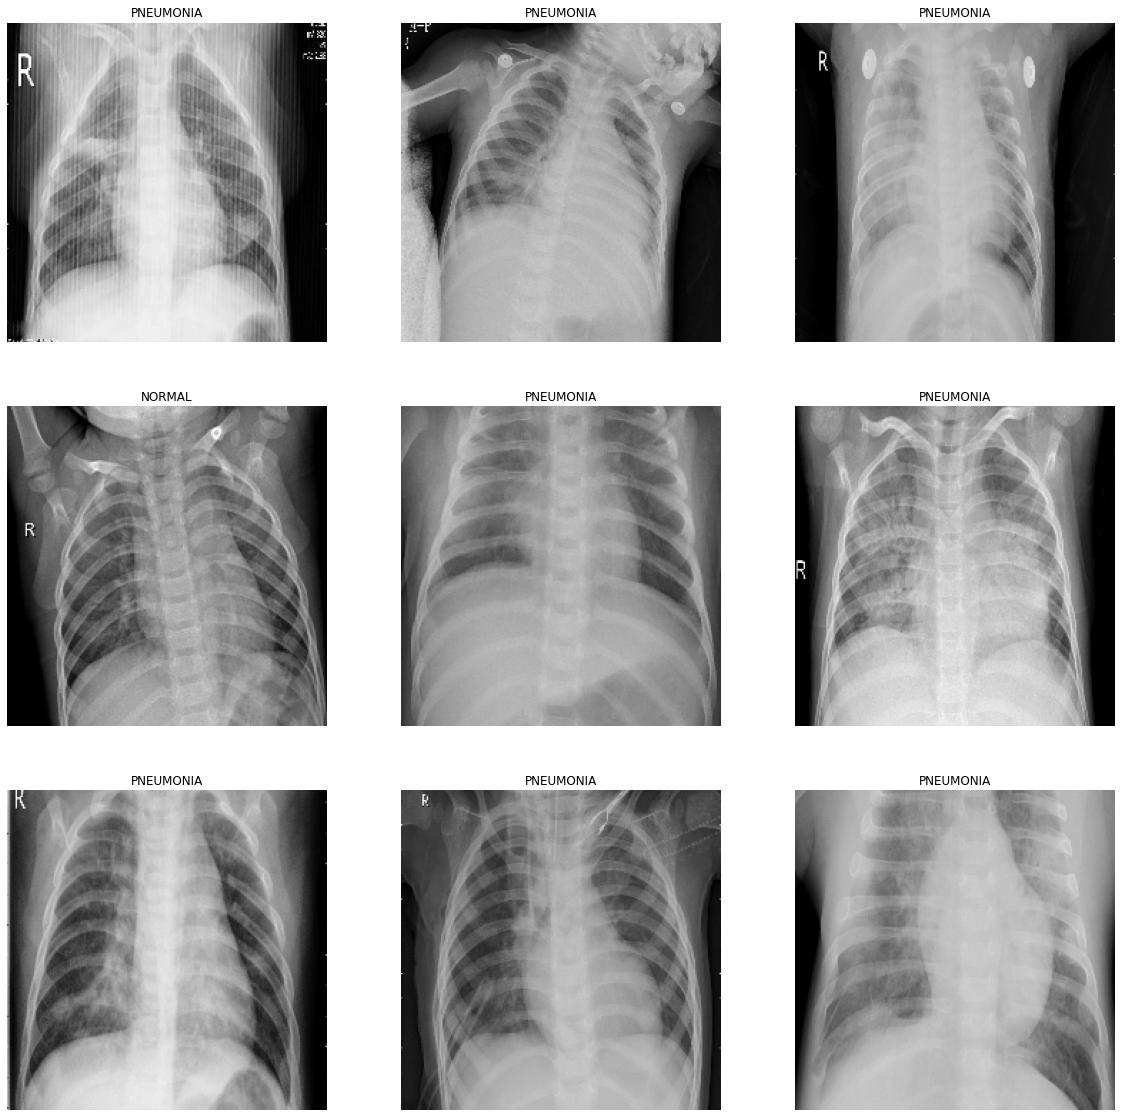

In [11]:
def show_img(images, labels):
    plt.figure(figsize=(20, 20))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

img,lbl = next(iter(train_ds))
show_img(img, lbl)

In [12]:
train_steps = train_image_count // batch_size
val_steps = val_image_count // batch_size

data_augment = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255),
                                    tf.keras.layers.RandomZoom(height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15)),
                                    tf.keras.layers.RandomRotation(0.2),
                                    tf.keras.layers.RandomFlip("horizontal"),
                                   ])

METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name = 'auc'),
          ]

In [13]:
test_labels = [(tf.strings.split(i, '/')[-2].numpy().decode('utf-8')) for i in test_data]
labels = []
for i in test_labels:
    if i == 'NORMAL':
        labels.append(0)
    elif i == 'PNEUMONIA':
        labels.append(1)
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [15]:
# tfimm.list_models('*vit*')

In [34]:
vit = tfimm.create_model('vit_base_patch16_224', pretrained="timm", num_classes=num_classes)

model=tf.keras.Sequential([data_augment,
                           vit,
#                            tf.keras.layers.Flatten(),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(64, activation = 'gelu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(1, activation = 'sigmoid')
                          ])

In [35]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2,),
                metrics = METRICS
                )

history = model.fit(train_ds,
                      validation_data = val_ds,
                      epochs = epochs,
                      class_weight=class_weights,
                      )

Epoch 1/10
131/131 [==============================] - 131s 848ms/step - loss: 0.5599 - accuracy: 0.7763 - precision: 0.9452 - recall: 0.7366 - auc: 0.8941 - val_loss: 0.8587 - val_accuracy: 0.3457 - val_precision: 1.0000 - val_recall: 0.0963 - val_auc: 0.9773
Epoch 2/10
131/131 [==============================] - 114s 833ms/step - loss: 0.4747 - accuracy: 0.8542 - precision: 0.9838 - recall: 0.8182 - auc: 0.9686 - val_loss: 0.8180 - val_accuracy: 0.7116 - val_precision: 1.0000 - val_recall: 0.6016 - val_auc: 0.9858
Epoch 3/10
131/131 [==============================] - 114s 830ms/step - loss: 0.4479 - accuracy: 0.8915 - precision: 0.9897 - recall: 0.8637 - auc: 0.9811 - val_loss: 0.4064 - val_accuracy: 0.9628 - val_precision: 0.9787 - val_recall: 0.9697 - val_auc: 0.9906
Epoch 4/10
131/131 [==============================] - 114s 830ms/step - loss: 0.4441 - accuracy: 0.9032 - precision: 0.9882 - recall: 0.8810 - auc: 0.9786 - val_loss: 0.4471 - val_accuracy: 0.9370 - val_precision: 0.9727

In [36]:
model.evaluate(test_ds)

20/20 [==============================] - 5s 255ms/step - loss: 0.4354 - accuracy: 0.9215 - precision: 0.9012 - recall: 0.9821 - auc: 0.9743


[0.43538567423820496,
 0.9214743375778198,
 0.9011764526367188,
 0.9820512533187866,
 0.9742603302001953]

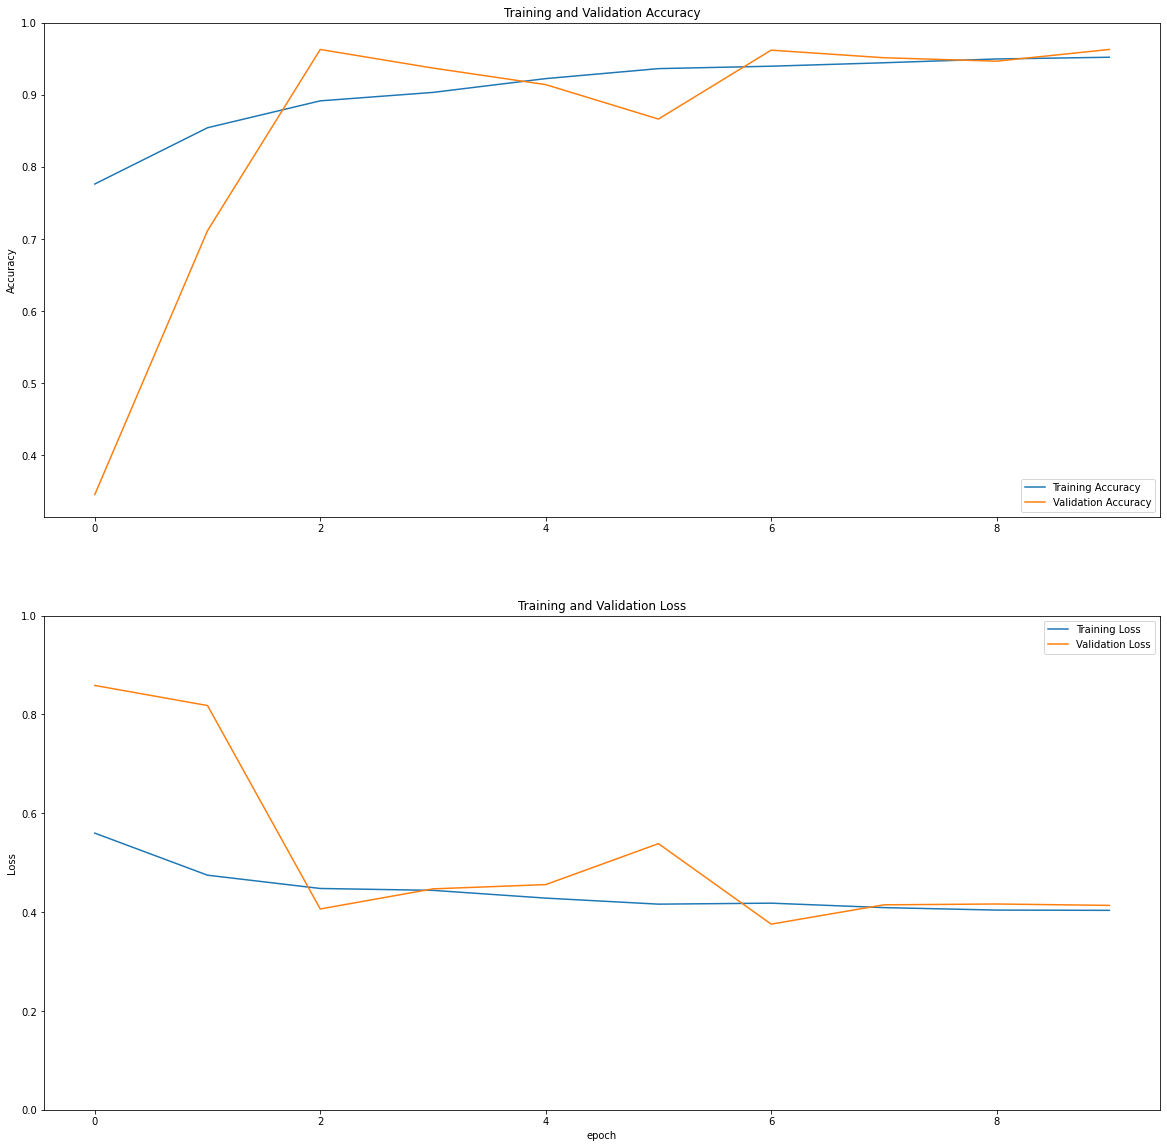

In [37]:
plot_graph(history)

In [38]:
pred = (model.predict(test_ds)>0.5).astype("int32")
print(classification_report(pred, labels))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       199
           1       0.98      0.90      0.94       425

    accuracy                           0.92       624
   macro avg       0.90      0.93      0.91       624
weighted avg       0.93      0.92      0.92       624



In [39]:
model.save('vit.h5')

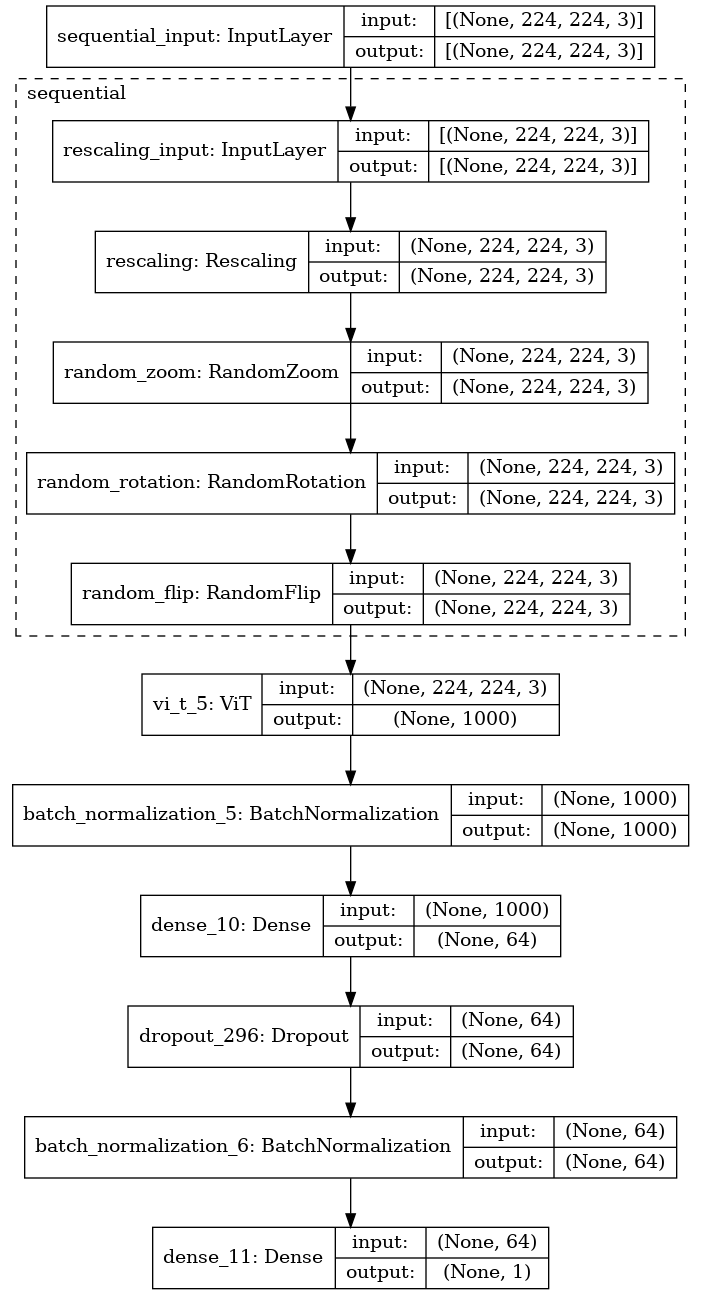

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [41]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
    ])
    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [42]:
from tensorflow.keras.applications import DenseNet201

base_model_1 = DenseNet201(include_top = False, input_shape = input_shape, weights = 'imagenet')

base_model_1.trainable = False

model_1 = tf.keras.Sequential([data_augment,
                               base_model_1,
                               conv_block(64),
                               tf.keras.layers.Dropout(0.3),
                               dense_block(64, 0.2),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

74850304/74836368 [==============================] - 1s 0us/step


In [43]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

model_1.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2,),
                metrics = METRICS
)

history_1 = model_1.fit(train_ds,
                      validation_data = val_ds,
                      epochs = epochs,
                      class_weight=class_weights
)

Epoch 1/10
131/131 [==============================] - 56s 278ms/step - loss: 0.5625 - accuracy: 0.8295 - precision: 0.9282 - recall: 0.8310 - auc: 0.9083 - val_loss: 0.4806 - val_accuracy: 0.8625 - val_precision: 0.8570 - val_recall: 0.9723 - val_auc: 0.9564
Epoch 2/10
131/131 [==============================] - 37s 245ms/step - loss: 0.4780 - accuracy: 0.8925 - precision: 0.9642 - recall: 0.8890 - auc: 0.9608 - val_loss: 0.5134 - val_accuracy: 0.8319 - val_precision: 0.9932 - val_recall: 0.7731 - val_auc: 0.9716
Epoch 3/10
131/131 [==============================] - 37s 242ms/step - loss: 0.4690 - accuracy: 0.9030 - precision: 0.9664 - recall: 0.9014 - auc: 0.9635 - val_loss: 0.4304 - val_accuracy: 0.9312 - val_precision: 0.9660 - val_recall: 0.9380 - val_auc: 0.9779
Epoch 4/10
131/131 [==============================] - 37s 247ms/step - loss: 0.4541 - accuracy: 0.9140 - precision: 0.9691 - recall: 0.9139 - auc: 0.9689 - val_loss: 0.4947 - val_accuracy: 0.8701 - val_precision: 0.9905 - v

In [44]:
model_1.evaluate(test_ds)

20/20 [==============================] - 4s 189ms/step - loss: 0.4940 - accuracy: 0.8542 - precision: 0.9628 - recall: 0.7974 - auc: 0.9537


[0.49404966831207275,
 0.8541666865348816,
 0.9628483057022095,
 0.7974358797073364,
 0.9537091255187988]

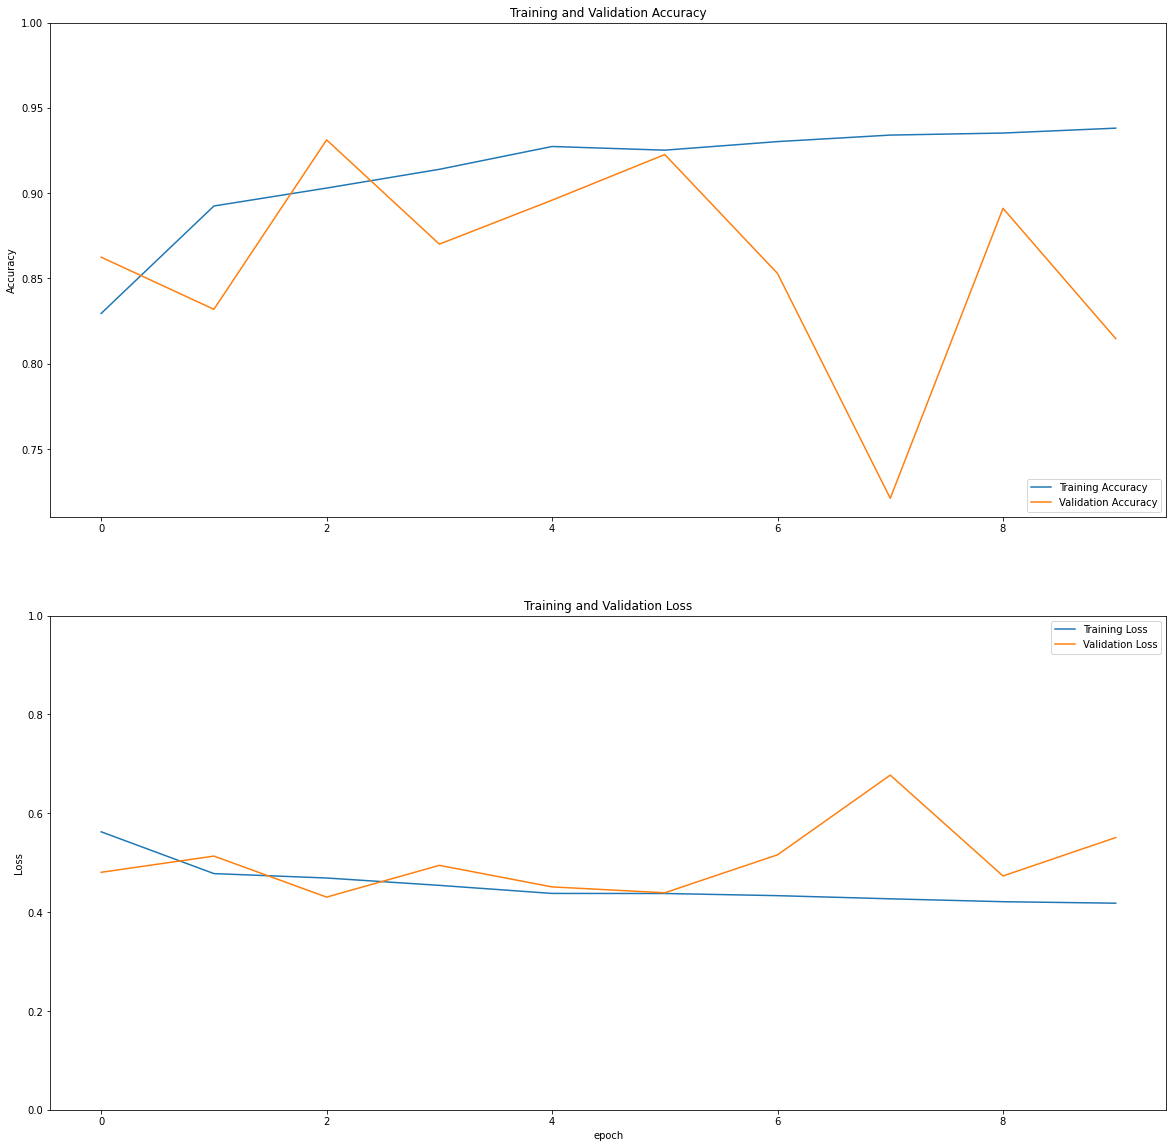

In [45]:
plot_graph(history_1)

In [46]:
pred_1 = (model_1.predict(test_ds)>0.5).astype("int32")
print(classification_report(pred_1, labels))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       301
           1       0.80      0.96      0.87       323

    accuracy                           0.85       624
   macro avg       0.87      0.85      0.85       624
weighted avg       0.87      0.85      0.85       624



In [47]:
from tensorflow.keras.applications import MobileNetV2

base_model_2 = MobileNetV2(include_top = False, input_shape = input_shape, weights = 'imagenet')

base_model_2.trainable = False

model_2 = tf.keras.Sequential([data_augment,
                               base_model_2,
                               conv_block(64),
                               tf.keras.layers.Dropout(0.3),
                               dense_block(64, 0.2),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

9420800/9406464 [==============================] - 0s 0us/step


In [48]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

model_2.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2,),
                metrics = METRICS
)

history_2 = model_2.fit(train_ds,
                      validation_data = val_ds,
                      epochs = epochs,
                      class_weight=class_weights
)

Epoch 1/10
131/131 [==============================] - 36s 206ms/step - loss: 0.5637 - accuracy: 0.8230 - precision: 0.9390 - recall: 0.8105 - auc: 0.9108 - val_loss: 0.4775 - val_accuracy: 0.8777 - val_precision: 0.9701 - val_recall: 0.8575 - val_auc: 0.9558
Epoch 2/10
131/131 [==============================] - 31s 197ms/step - loss: 0.4882 - accuracy: 0.8793 - precision: 0.9606 - recall: 0.8742 - auc: 0.9538 - val_loss: 0.7594 - val_accuracy: 0.6848 - val_precision: 0.9954 - val_recall: 0.5673 - val_auc: 0.9513
Epoch 3/10
131/131 [==============================] - 31s 196ms/step - loss: 0.4796 - accuracy: 0.8875 - precision: 0.9624 - recall: 0.8838 - auc: 0.9580 - val_loss: 0.5495 - val_accuracy: 0.8290 - val_precision: 0.9932 - val_recall: 0.7691 - val_auc: 0.9699
Epoch 4/10
131/131 [==============================] - 30s 193ms/step - loss: 0.4591 - accuracy: 0.9044 - precision: 0.9693 - recall: 0.9005 - auc: 0.9673 - val_loss: 0.5298 - val_accuracy: 0.8520 - val_precision: 0.9935 - v

In [49]:
model_2.evaluate(test_ds)

20/20 [==============================] - 3s 131ms/step - loss: 0.4851 - accuracy: 0.8750 - precision: 0.9000 - recall: 0.9000 - auc: 0.9312


[0.48510801792144775,
 0.875,
 0.8999999761581421,
 0.8999999761581421,
 0.9312238693237305]

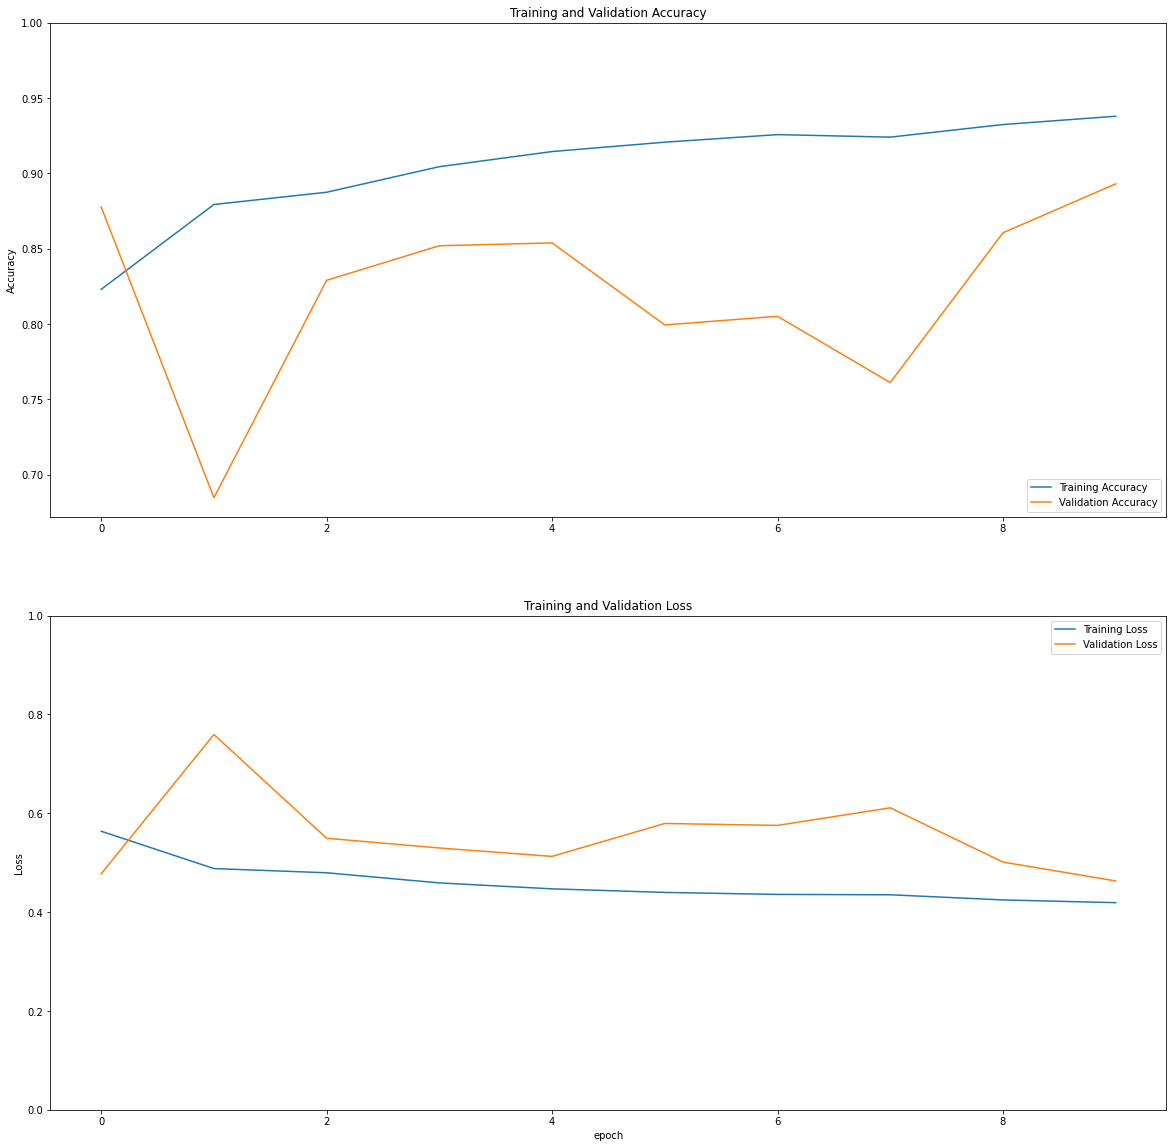

In [50]:
plot_graph(history_2)

In [51]:
pred_2 = (model_2.predict(test_ds)>0.5).astype("int32")
print(classification_report(pred_2, labels))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       234
           1       0.90      0.90      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



In [52]:
from tensorflow.keras.applications import Xception

base_model_3 = Xception(include_top = False, input_shape = input_shape, weights = 'imagenet')
base_model_3.trainable = False
model_3 = tf.keras.Sequential([data_augment,
                              base_model_3,
                               conv_block(64),
                               tf.keras.layers.Dropout(0.3),
                               dense_block(64, 0.2),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

83697664/83683744 [==============================] - 1s 0us/step


In [53]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

model_3.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2,),
                metrics = METRICS
)

history_3 = model_3.fit(train_ds,
                      validation_data = val_ds,
                      epochs = epochs,
                      class_weight=class_weights
                        
)

Epoch 1/10
131/131 [==============================] - 40s 239ms/step - loss: 0.5610 - accuracy: 0.8314 - precision: 0.9308 - recall: 0.8310 - auc: 0.9038 - val_loss: 0.6709 - val_accuracy: 0.6743 - val_precision: 0.9883 - val_recall: 0.5567 - val_auc: 0.9471
Epoch 2/10
131/131 [==============================] - 35s 226ms/step - loss: 0.4982 - accuracy: 0.8695 - precision: 0.9529 - recall: 0.8682 - auc: 0.9439 - val_loss: 0.5254 - val_accuracy: 0.8300 - val_precision: 0.9817 - val_recall: 0.7797 - val_auc: 0.9631
Epoch 3/10
131/131 [==============================] - 35s 228ms/step - loss: 0.4733 - accuracy: 0.8932 - precision: 0.9633 - recall: 0.8909 - auc: 0.9596 - val_loss: 0.4473 - val_accuracy: 0.9198 - val_precision: 0.9655 - val_recall: 0.9222 - val_auc: 0.9728
Epoch 4/10
131/131 [==============================] - 34s 227ms/step - loss: 0.4723 - accuracy: 0.8970 - precision: 0.9613 - recall: 0.8982 - auc: 0.9605 - val_loss: 0.5793 - val_accuracy: 0.8090 - val_precision: 0.9947 - v

In [54]:
model_3.evaluate(test_ds)

20/20 [==============================] - 3s 154ms/step - loss: 0.4824 - accuracy: 0.8590 - precision: 0.9441 - recall: 0.8231 - auc: 0.9543


[0.4824465811252594,
 0.8589743375778198,
 0.9441176652908325,
 0.8230769038200378,
 0.9542680978775024]

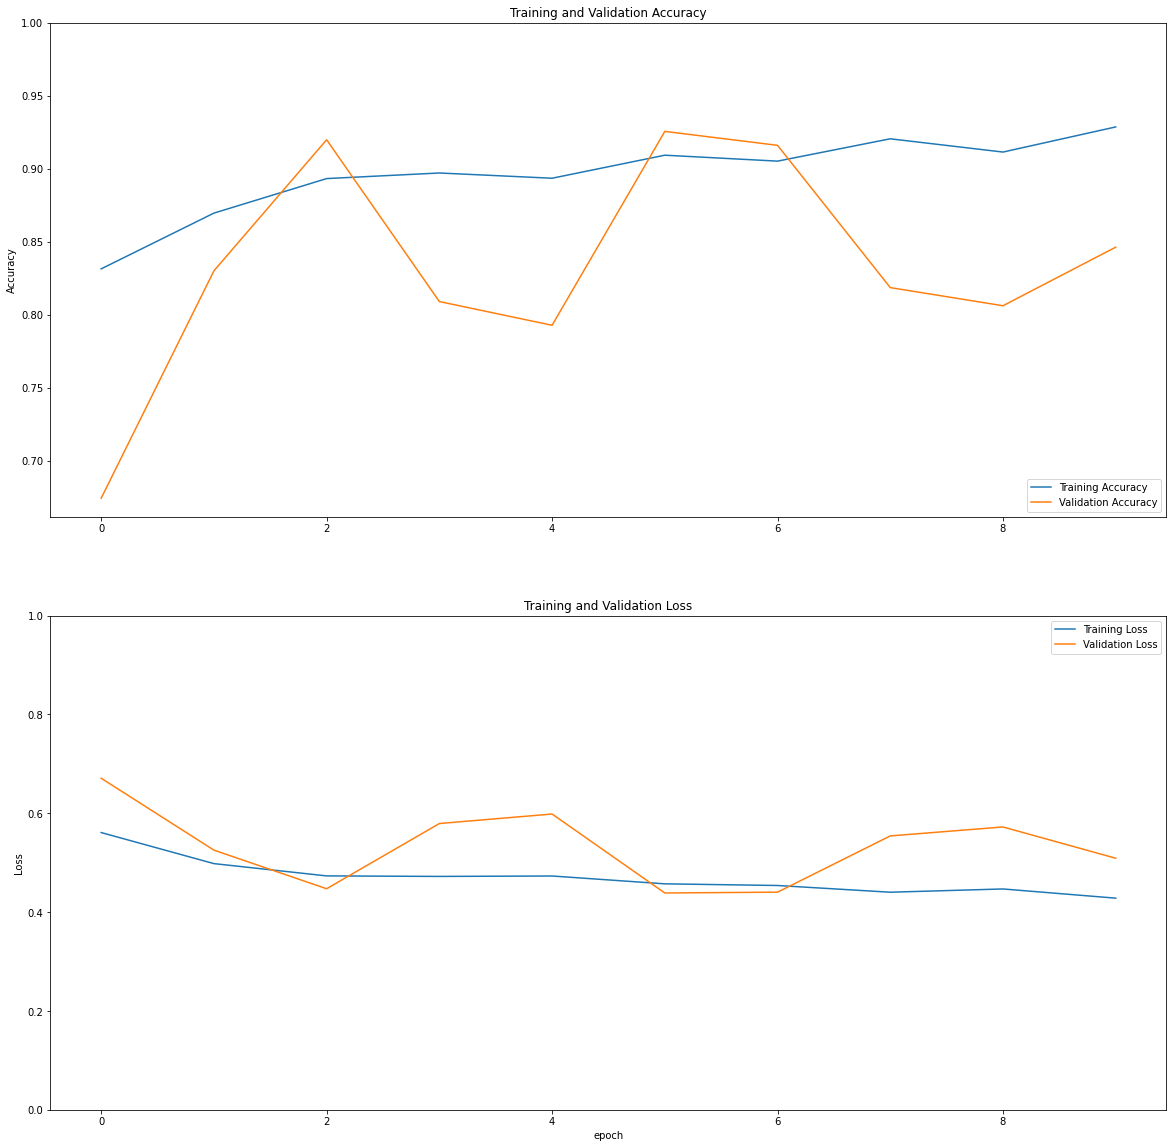

In [55]:
plot_graph(history_3)

In [56]:
pred_3 = (model_3.predict(test_ds)>0.5).astype("int32")
print(classification_report(pred_3, labels))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       284
           1       0.82      0.94      0.88       340

    accuracy                           0.86       624
   macro avg       0.87      0.85      0.85       624
weighted avg       0.87      0.86      0.86       624



In [57]:
from tensorflow.keras.applications import VGG19

base_model_4 = VGG19(include_top = False, input_shape = input_shape, weights = 'imagenet')
base_model_4.trainable = False
model_4 = tf.keras.Sequential([data_augment,
                              base_model_3,
                               conv_block(64),
                               tf.keras.layers.Dropout(0.3),
                               dense_block(64, 0.2),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')
                             ])

80150528/80134624 [==============================] - 0s 0us/step


In [58]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

model_4.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2,),
                metrics = METRICS
)

history_4 = model_4.fit(train_ds,
                      validation_data = val_ds,
                      epochs = epochs,
                      class_weight=class_weights
)

Epoch 1/10
131/131 [==============================] - 40s 239ms/step - loss: 0.5607 - accuracy: 0.8153 - precision: 0.9288 - recall: 0.8094 - auc: 0.9045 - val_loss: 0.5137 - val_accuracy: 0.8204 - val_precision: 0.9914 - val_recall: 0.7586 - val_auc: 0.9699
Epoch 2/10
131/131 [==============================] - 35s 226ms/step - loss: 0.4947 - accuracy: 0.8707 - precision: 0.9598 - recall: 0.8630 - auc: 0.9449 - val_loss: 0.4497 - val_accuracy: 0.9026 - val_precision: 0.9469 - val_recall: 0.9169 - val_auc: 0.9658
Epoch 3/10
131/131 [==============================] - 35s 230ms/step - loss: 0.4791 - accuracy: 0.8901 - precision: 0.9648 - recall: 0.8851 - auc: 0.9551 - val_loss: 0.4951 - val_accuracy: 0.8653 - val_precision: 0.9843 - val_recall: 0.8272 - val_auc: 0.9672
Epoch 4/10
131/131 [==============================] - 35s 229ms/step - loss: 0.4671 - accuracy: 0.9004 - precision: 0.9659 - recall: 0.8982 - auc: 0.9616 - val_loss: 0.5255 - val_accuracy: 0.8376 - val_precision: 0.9933 - v

In [59]:
model_4.evaluate(test_ds)

20/20 [==============================] - 3s 164ms/step - loss: 0.5569 - accuracy: 0.8013 - precision: 0.9716 - recall: 0.7026 - auc: 0.9469


[0.5569287538528442,
 0.8012820482254028,
 0.9716312289237976,
 0.7025641202926636,
 0.9469373822212219]

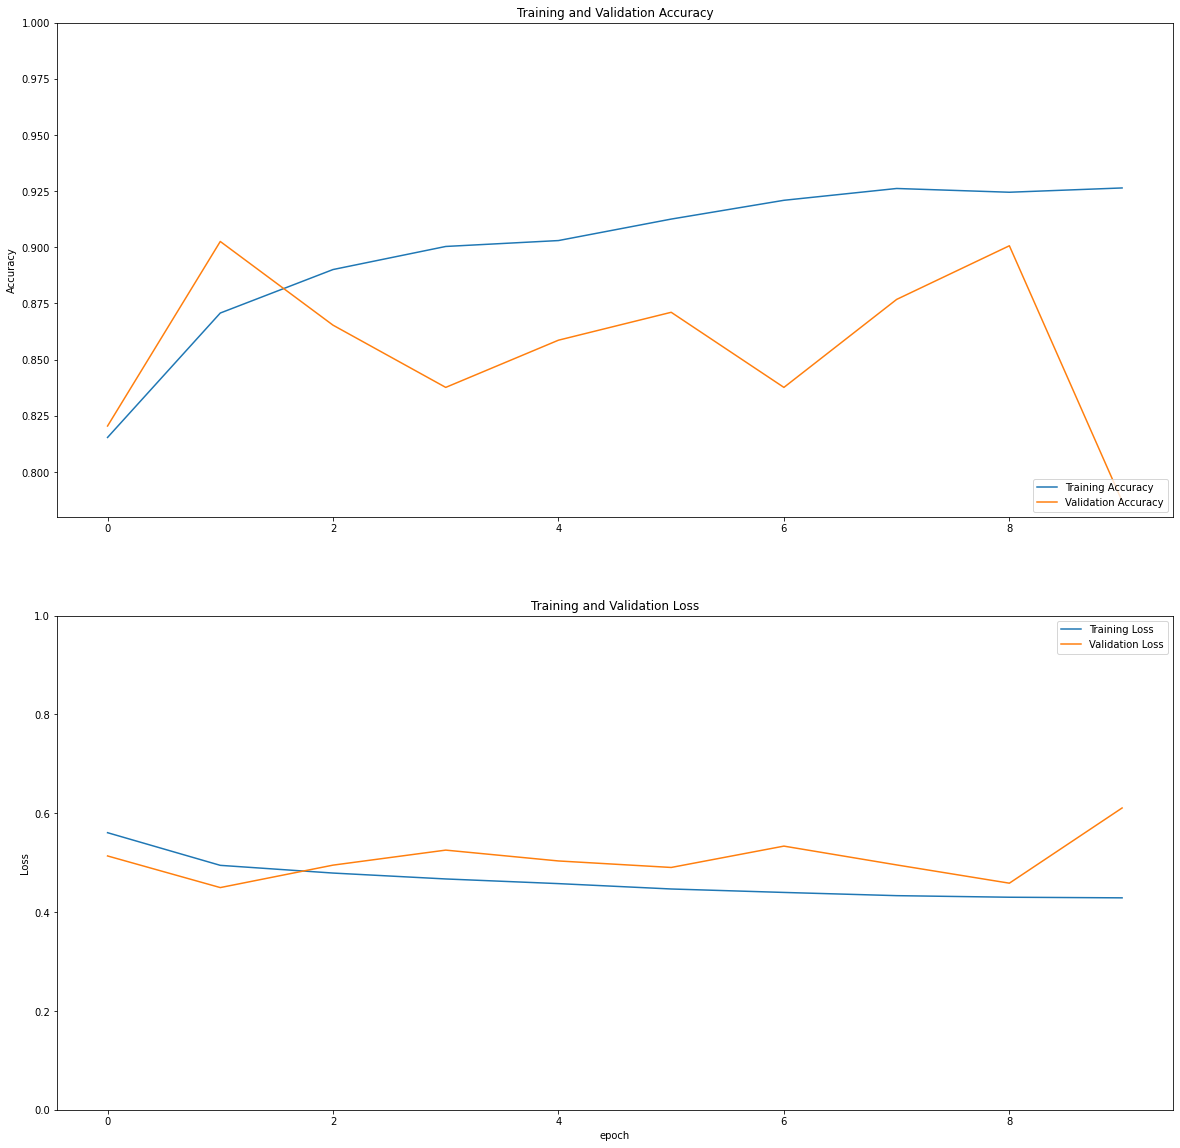

In [60]:
plot_graph(history_4)

In [61]:
pred_4 = (model_4.predict(test_ds)>0.5).astype("int32")
print(classification_report(pred_4, labels))

              precision    recall  f1-score   support

           0       0.97      0.66      0.78       342
           1       0.70      0.97      0.82       282

    accuracy                           0.80       624
   macro avg       0.83      0.82      0.80       624
weighted avg       0.85      0.80      0.80       624

